# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [2]:
# These are all of the files you are given
df_tr = pd.read_csv("train.csv")

In [48]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,8,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,8,0
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,8,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,8,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,8,0


### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [49]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [5]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

### Create a Prediction File

In [6]:
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=716.4264615618442 median=600.0 std=684.7511617508213


In [7]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

Using: 1692771/1710670


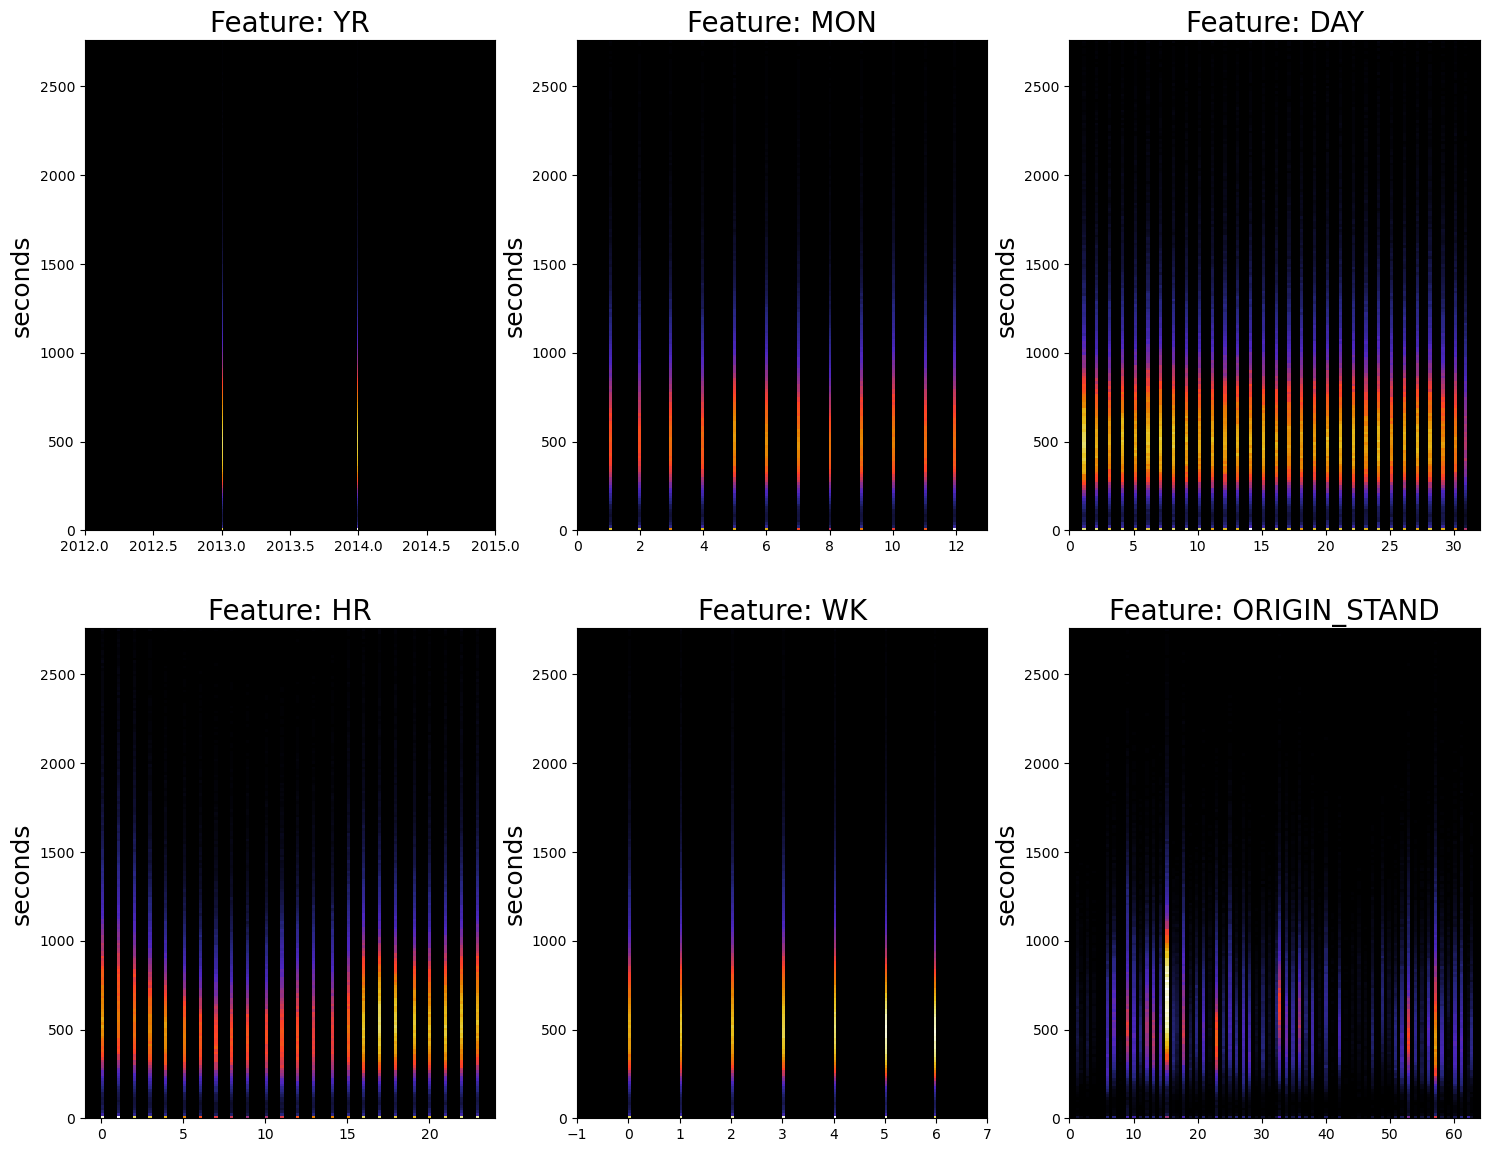

In [51]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


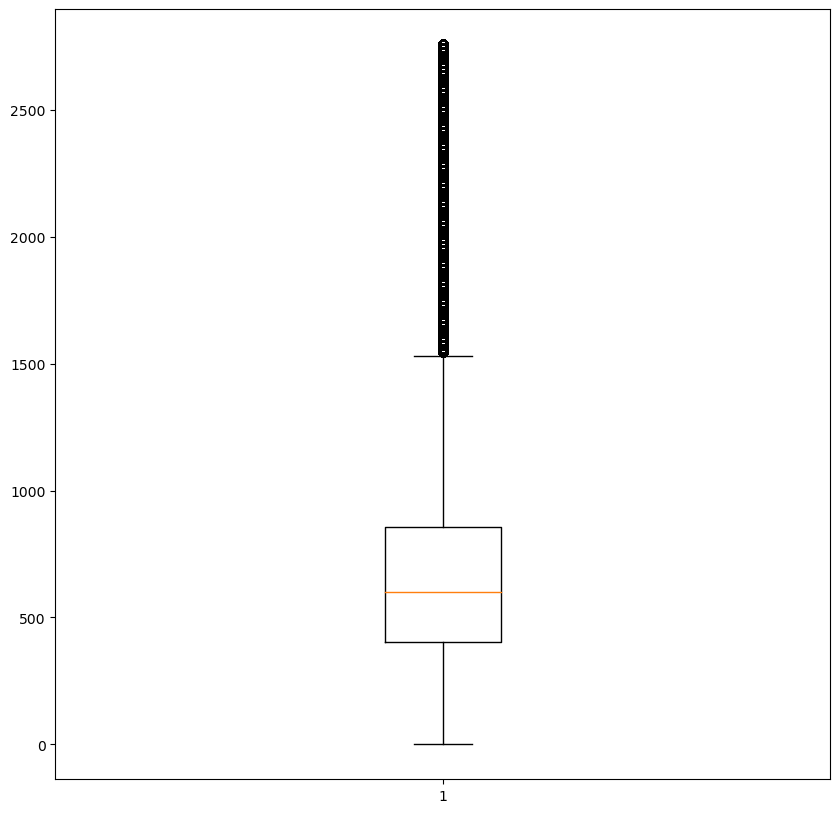

In [52]:
# using box plot distribution of 'LEN'
plt.figure(figsize=(10,10))
plt.boxplot(df_trimmed['LEN'])
plt.show()

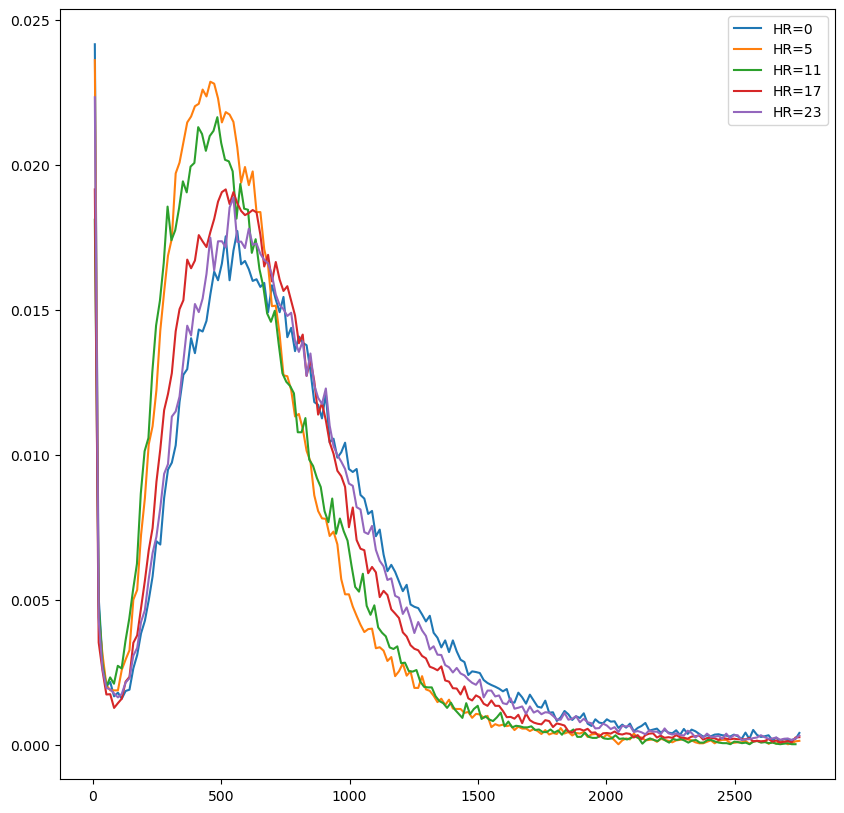

In [54]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

In [ ]:
import ast

# get list type of coordinate
df_tr['POLYLINE'] = df_tr['POLYLINE'].apply(ast.literal_eval)
coordinates = []
for polyline in df_tr['POLYLINE']:
    for coordinate in polyline:
        coordinates.append(coordinate)

# make new df
coordinates_df = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'])

# remove illegal value
coordinates_df = coordinates_df[(coordinates_df['Latitude']> -90) & (coordinates_df['Latitude']< 90) & (coordinates_df['Longitude']> -180) & (coordinates_df['Longitude']< 180)]

# sample a million data to plot heatmap
sample_df = coordinates_df.sample(n=1000000)

# normalize data
def rescale(series):
    min_val = series.min()
    max_val = series.max()
    return 100 * (series - min_val) / (max_val - min_val)

sample_df['Longitude'] = rescale(sample_df['Longitude'])
sample_df['Latitude'] = rescale(sample_df['Latitude'])

# remove outliers
sample_df = sample_df[(sample_df['Latitude']> 22) & (sample_df['Latitude']< 26) & (sample_df['Longitude']> 80) & (sample_df['Longitude']< 83)]

# normalize again
sample_df['Longitude'] = rescale(sample_df['Longitude'])
sample_df['Latitude'] = rescale(sample_df['Latitude'])

# plot heatmap
plt.hist2d(sample_df['Longitude'], sample_df['Latitude'], bins=(100,100), cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Latitude and Longitude')
plt.show()


In [89]:
train_data = df_tr.copy()

In [56]:
df_tr['CALL_TYPE'].value_counts()

B    817881
C    528019
A    364770
Name: CALL_TYPE, dtype: int64

In [57]:
# for each taxi_id in df_tr, group them and get mean of LEN, then print and plot
print(df_tr.groupby("TAXI_ID")["LEN"].mean())
print(df_tr.groupby("TAXI_ID")["LEN"].std())

TAXI_ID
20000001    934.834846
20000002    710.222280
20000003    584.344046
20000004    781.875380
20000005    643.911866
               ...    
20000941     79.687500
20000969    184.672131
20000970      0.000000
20000980      0.000000
20000981      1.578947
Name: LEN, Length: 448, dtype: float64
TAXI_ID
20000001    978.662460
20000002    800.447233
20000003    412.944451
20000004    486.553571
20000005    482.698574
               ...    
20000941    254.306041
20000969    415.895489
20000970           NaN
20000980      0.000000
20000981      6.882472
Name: LEN, Length: 448, dtype: float64


<Axes: xlabel='TAXI_ID'>

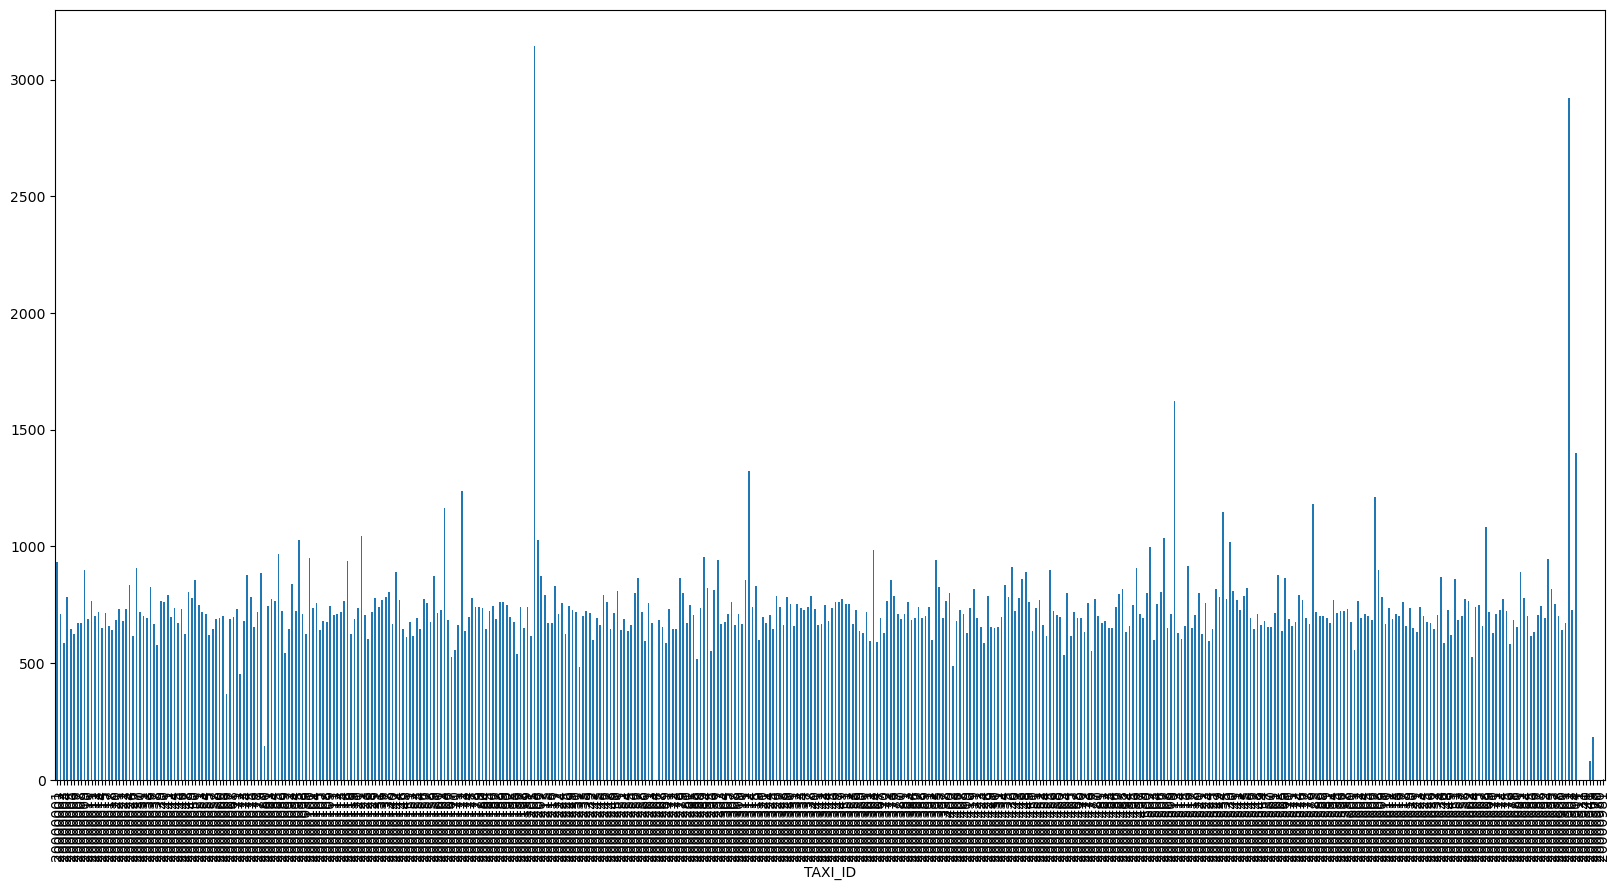

In [58]:
# use bar chats show mean and std of grouped TEXI_ID's LEN
df_tr.groupby("TAXI_ID")["LEN"].mean().plot(kind="bar", figsize=(20, 10))

<Axes: xlabel='TAXI_ID'>

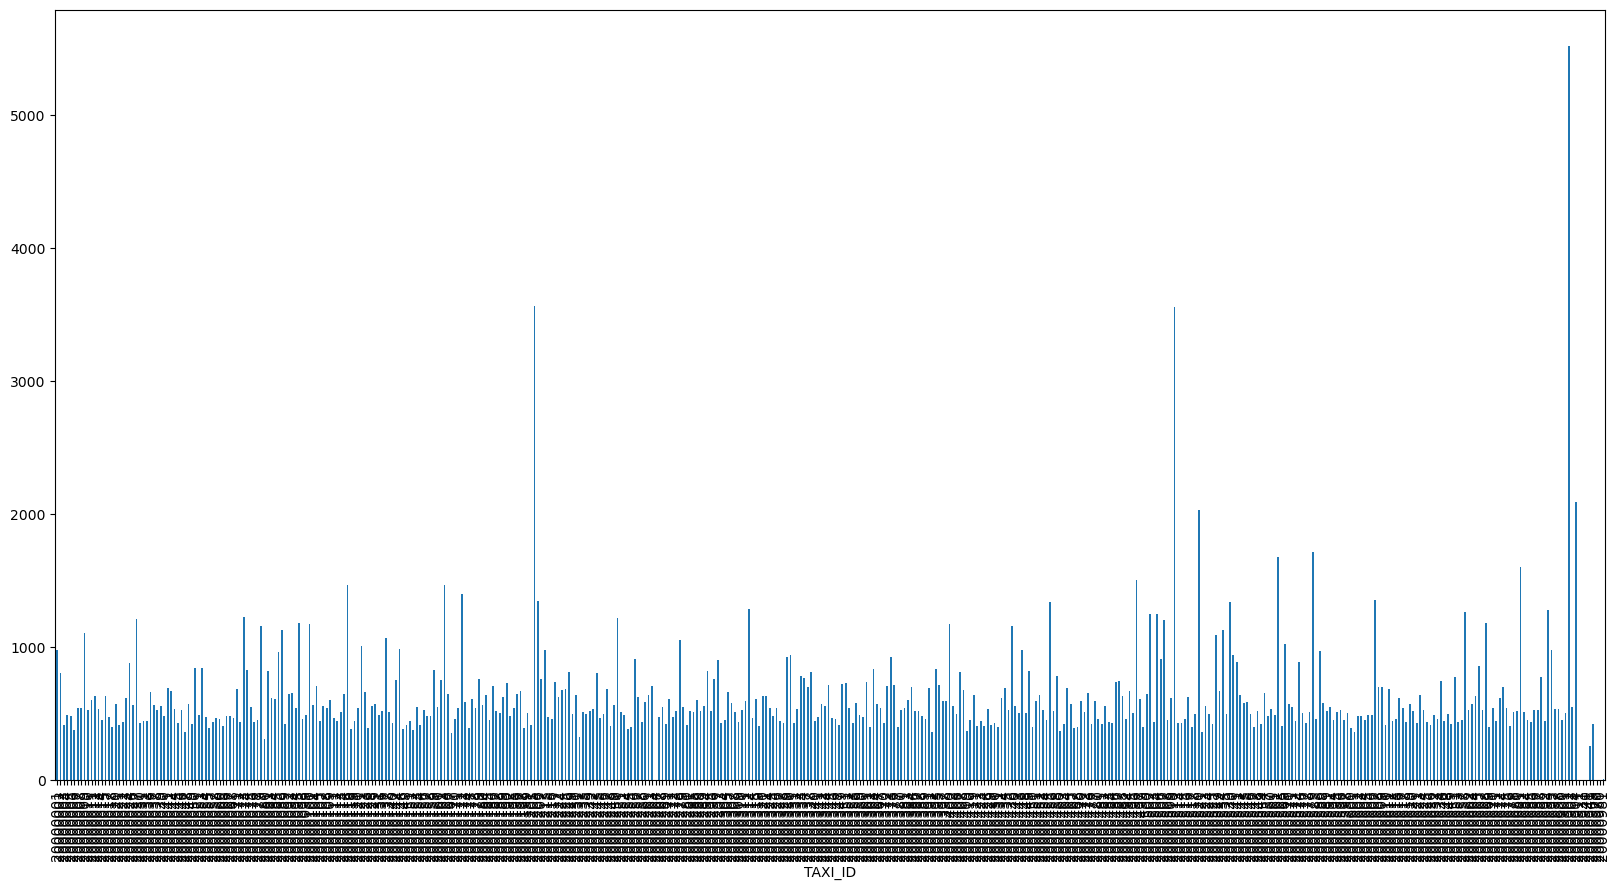

In [59]:
df_tr.groupby("TAXI_ID")["LEN"].std().plot(kind="bar", figsize=(20, 10))

In [90]:
# convert column TAXI_ID to its mean LEN and std LEN
train_data["TAXI_ID_MEAN"] = train_data["TAXI_ID"].map(train_data.groupby("TAXI_ID")["LEN"].mean())
train_data["TAXI_ID_STD"] = train_data["TAXI_ID"].map(train_data.groupby("TAXI_ID")["LEN"].std())

In [61]:
# check how many row has a "Missing value" column = True
train_data["MISSING_DATA"].value_counts()

False    1710660
True          10
Name: MISSING_DATA, dtype: int64

In [91]:
# drop all rows with "Missing value" column = True
train_data = train_data[train_data["MISSING_DATA"] == False]

In [92]:
# check orginal call value counts
train_data["ORIGIN_CALL"].value_counts()

2002.0     57571
63882.0     6406
2001.0      2499
13168.0     1314
6728.0      1115
           ...  
23600.0        1
37142.0        1
7028.0         1
49288.0        1
34164.0        1
Name: ORIGIN_CALL, Length: 57105, dtype: int64

In [93]:
# for each taxi_id in df_tr, group them and get mean of LEN, then print and plot
print(train_data.groupby("ORIGIN_CALL")["LEN"].mean())
print(train_data.groupby("ORIGIN_CALL")["LEN"].std())

ORIGIN_CALL
2001.0     728.607443
2002.0     841.306908
2003.0     195.000000
2004.0     315.000000
2006.0     945.000000
              ...    
63878.0    405.000000
63880.0    675.000000
63882.0    773.455354
63883.0    885.000000
63884.0    990.000000
Name: LEN, Length: 57105, dtype: float64
ORIGIN_CALL
2001.0     625.747912
2002.0     587.177209
2003.0            NaN
2004.0            NaN
2006.0     615.182900
              ...    
63878.0           NaN
63880.0           NaN
63882.0    518.849300
63883.0           NaN
63884.0     42.426407
Name: LEN, Length: 57105, dtype: float64


In [94]:

# convert column ORIGIN_CALL to its mean LEN and std LEN
train_data["ORIGIN_CALL_MEAN"] = train_data["ORIGIN_CALL"].map(df_tr.groupby("ORIGIN_CALL")["LEN"].mean())
train_data["ORIGIN_CALL_STD"] = train_data["ORIGIN_CALL"].map(df_tr.groupby("ORIGIN_CALL")["LEN"].std())

In [95]:
# drop useless column
train_drop = train_data.drop(columns=["MISSING_DATA", "POLYLINE", "ORIGIN_CALL", "TAXI_ID", "TIMESTAMP", "TRIP_ID", "DAY_TYPE", "YR"])

In [96]:
# check start position
train_drop["ORIGIN_STAND"].value_counts()

15.0    80241
57.0    50882
9.0     34818
33.0    34128
23.0    33343
        ...  
41.0      506
43.0      493
8.0       381
5.0        53
48.0        7
Name: ORIGIN_STAND, Length: 63, dtype: int64

<Axes: >

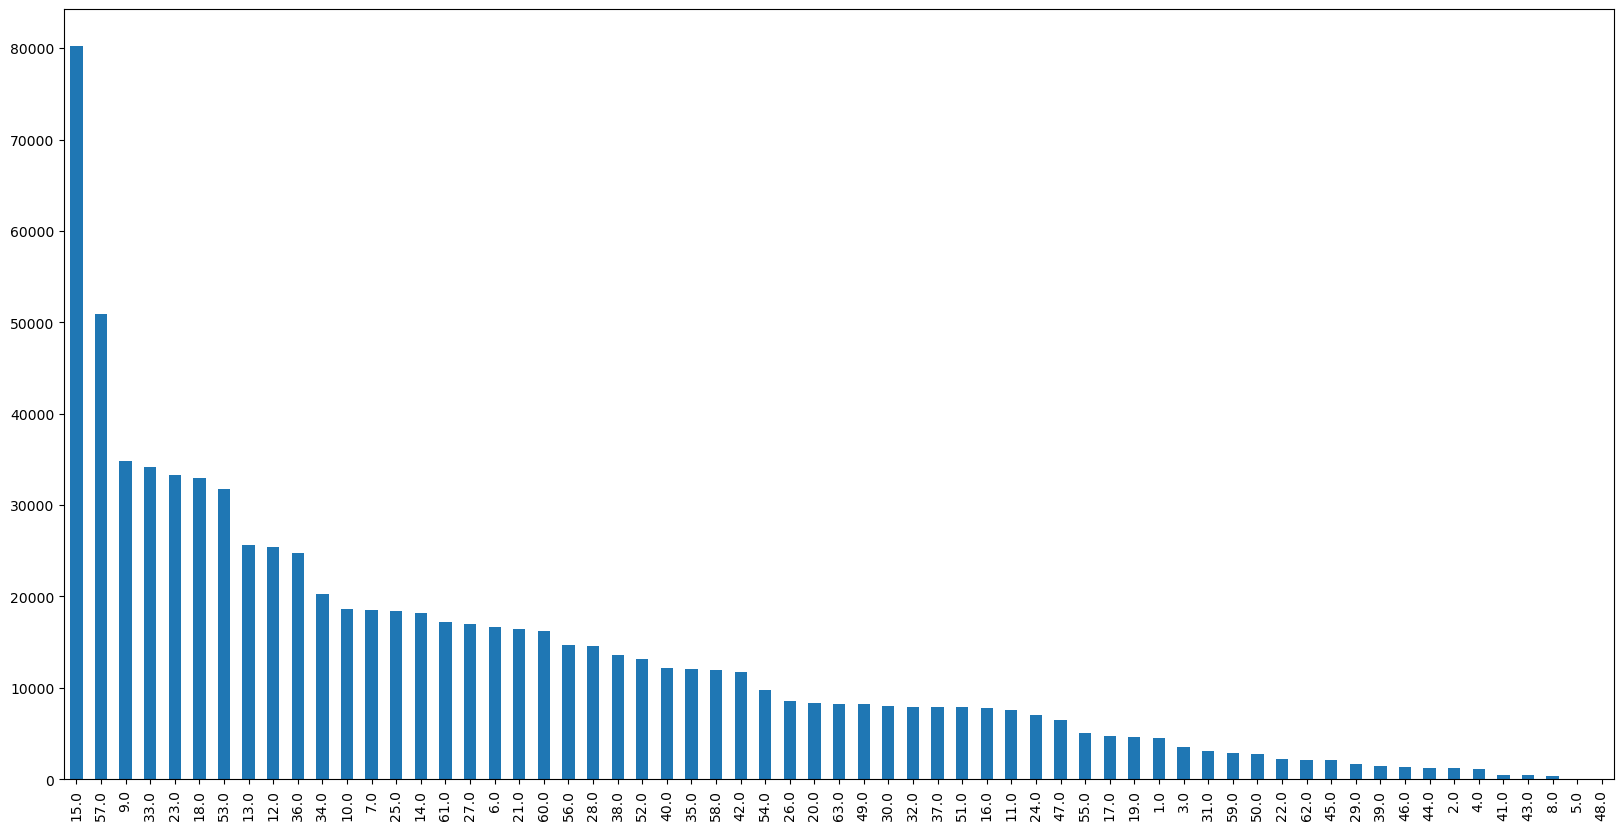

In [97]:
# use bar chart to visualize start position count
train_drop["ORIGIN_STAND"].value_counts().plot(kind="bar", figsize=(20, 10))

In [98]:
# original stand is an integer indicate a position ID, combine metaData_taxistandsID_name_GPSlocation.csv, and merge this file to my dataset train_data, replace original stand with Latitude and Longitude
taxi_stand = pd.read_csv("metaData_taxistandsID_name_GPSlocation.csv")

In [99]:
# merge taxi_stand to train_data
train_merge = train_drop.merge(taxi_stand, left_on="ORIGIN_STAND", right_on="ID")

In [100]:
# remove in train_data where CALL_TYPE is 'B'
train_drop = train_drop[train_drop["CALL_TYPE"] != "B"]

In [101]:
# drop useless columns in tran_merge
train_merge = train_merge.drop(columns=["ID", "ORIGIN_STAND", "Descricao"])

In [102]:
train_drop = train_drop.drop(columns=["ORIGIN_STAND"])

In [103]:
# add two columns to train_data, Latitude and Longitude, using NaN
train_drop["Latitude"] = np.nan
train_drop["Longitude"] = np.nan

In [104]:
# concat
train_data_final = pd.concat([train_drop, train_merge])

In [105]:
train_data_final['CALL_TYPE'] = train_data_final['CALL_TYPE'].astype('category')
train_data_final['Latitude'] = train_data_final['Latitude'].astype(float)
train_data_final['Longitude'] = train_data_final['Longitude'].astype(float)

In [106]:
# one-hot coding for call_type and day_type
train_data_final = pd.get_dummies(train_data_final, columns=["CALL_TYPE"])

In [107]:
# clip taxi_id_mean taxi_id_std, origin_call_mean, origin_call_std to mean+-3*std
train_data_final["TAXI_ID_MEAN"] = train_data_final["TAXI_ID_MEAN"].clip(train_data_final["TAXI_ID_MEAN"].mean() - 3 * train_data_final["TAXI_ID_STD"].std(), train_data_final["TAXI_ID_MEAN"].mean() + 3 * train_data_final["TAXI_ID_STD"].std())
train_data_final["TAXI_ID_STD"] = train_data_final["TAXI_ID_STD"].clip(train_data_final["TAXI_ID_STD"].mean() - 3 * train_data_final["TAXI_ID_STD"].std(), train_data_final["TAXI_ID_STD"].mean() + 3 * train_data_final["TAXI_ID_STD"].std())
train_data_final["ORIGIN_CALL_MEAN"] = train_data_final["ORIGIN_CALL_MEAN"].clip(train_data_final["ORIGIN_CALL_MEAN"].mean() - 3 * train_data_final["ORIGIN_CALL_STD"].std(), train_data_final["ORIGIN_CALL_MEAN"].mean() + 3 * train_data_final["ORIGIN_CALL_STD"].std())
train_data_final["ORIGIN_CALL_STD"] = train_data_final["ORIGIN_CALL_STD"].clip(train_data_final["ORIGIN_CALL_STD"].mean() - 3 * train_data_final["ORIGIN_CALL_STD"].std(), train_data_final["ORIGIN_CALL_STD"].mean() + 3 * train_data_final["ORIGIN_CALL_STD"].std())

In [108]:
train_data_final.describe()

,LEN,MON,DAY,HR,WK,TAXI_ID_MEAN,TAXI_ID_STD,ORIGIN_CALL_MEAN,ORIGIN_CALL_STD,Latitude,Longitude,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C
count,1.699358e+06,1.699358e+06,1.699358e+06,1.699358e+06,1.699358e+06,1.699358e+06,1.699355e+06,364769.000000,336690.000000,806576.000000,806576.000000,1.699358e+06,1.699358e+06,1.699358e+06
mean,7.161468e+02,6.582875e+00,1.555110e+01,1.220886e+01,3.134439e+00,7.142585e+02,5.944093e+02,744.377370,394.998554,41.155731,-8.613889,2.146511e-01,4.746357e-01,3.107132e-01
std,6.852099e+02,3.411445e+00,8.840025e+00,7.383322e+00,1.981383e+00,1.205141e+02,2.239296e+02,219.587769,203.705748,0.011218,0.020803,4.105802e-01,4.993564e-01,4.627857e-01
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,17.845627,0.000000,41.140517,-8.689180,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.050000e+02,4.000000e+00,8.000000e+00,5.000000e+00,1.000000e+00,6.585448e+02,4.492370e+02,597.000000,242.367308,41.148032,-8.627759,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.000000e+02,7.000000e+00,1.500000e+01,1.300000e+01,3.000000e+00,7.037098e+02,5.254408e+02,753.840000,360.624458,41.151784,-8.611071,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.700000e+02,1.000000e+01,2.300000e+01,1.900000e+01,5.000000e+00,7.583524e+02,6.470279e+02,841.306908,587.177209,41.161081,-8.602539,0.000000e+00,1.000000e+00,1.000000e+00
max,5.820000e+04,1.200000e+01,3.100000e+01,2.300000e+01,6.000000e+00,1.583428e+03,1.470644e+03,1482.831251,1132.814098,41.183510,-8.568195,1.000000e+00,1.000000e+00,1.000000e+00


In [35]:
from sklearn.model_selection import train_test_split

# LEN is regression target, split train_x, train_y, test_x and test_y, train_data_final is the final dataset
train_x, test_x, train_y, test_y = train_test_split(train_data_final.drop(columns=["LEN"]), train_data_final["LEN"], test_size=0.2, random_state=42)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [65]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(13, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return torch.squeeze(self.layers(x))


class TaxiDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = self.data.iloc[idx].drop('LEN')
        target = self.data.iloc[idx]['LEN']

        return torch.tensor(features.values, dtype=torch.float32).to(device), torch.tensor(target, dtype=torch.float32).to(device)

train_data, test_data = train_test_split(train_data_final, test_size=0.1, random_state=42)

# train_sample = train_data.sample(n=20000).fillna(0)
# test_sample = train_sample.sample(n=1000).fillna(0)

train_dataset = TaxiDataset(train_data.fillna(0))
test_dataset = TaxiDataset(test_data.fillna(0))
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = MLP().to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.00001)

train_history = []
test_history = []
# train model
for epoch in range(100):
    # print('train')
    model.train()
    train_loss = 0
    for inputs, labels in trainloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('test')
    # evaluate
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    print(f"Epoch {epoch+1} Training Loss: {(train_loss/len(trainloader))**0.5}, Test Loss: {(test_loss/len(testloader))**0.5}")
    train_history.append((train_loss/len(trainloader))**0.5)
    test_history.append((test_loss/len(testloader))**0.5)

    # save in each step
    # torch.save(model.state_dict(), "model.pth")


Epoch 1 Training Loss: 910.9651018151025, Test Loss: 764.1382084807409
Epoch 2 Training Loss: 784.0405979603353, Test Loss: 642.1039097437448
Epoch 3 Training Loss: 687.2933298090416, Test Loss: 575.3748267731042
Epoch 4 Training Loss: 648.4761892698914, Test Loss: 562.1657182715828
Epoch 5 Training Loss: 642.1013311580969, Test Loss: 561.1735618144285
Epoch 6 Training Loss: 641.1324809175558, Test Loss: 560.4883636709569
Epoch 7 Training Loss: 640.5931000057681, Test Loss: 559.6995960489724
Epoch 8 Training Loss: 640.1622654843068, Test Loss: 559.0233350329198
Epoch 9 Training Loss: 639.748413821793, Test Loss: 558.6918561138068
Epoch 10 Training Loss: 639.3406055998242, Test Loss: 557.8380713457746
Epoch 11 Training Loss: 639.0083692429231, Test Loss: 557.3309278907764
Epoch 12 Training Loss: 638.6483312727748, Test Loss: 556.9727210002986
Epoch 13 Training Loss: 638.3052329362105, Test Loss: 556.468126122804
Epoch 14 Training Loss: 637.9986667354799, Test Loss: 555.9550631360079
Epo

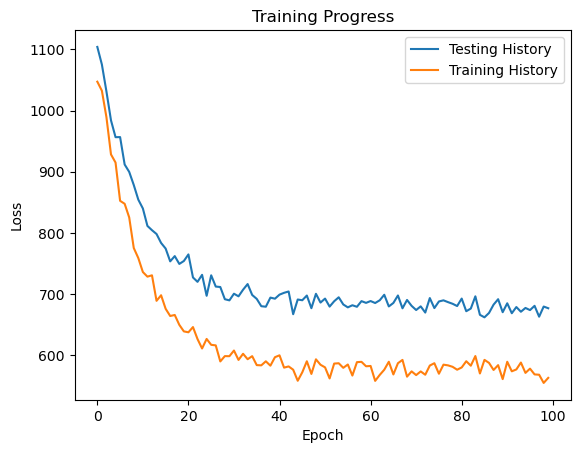

In [87]:
plt.plot(test_history, label='Testing History')
plt.plot(train_history, label='Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.show()

In [ ]:
# draw the difference of top-20 samples
diff = np.abs(np.array(list1) - np.array(list2))
sorted_indices = np.argsort(diff)
top_10_indices = sorted_indices[-10:]

# 提取差异最大的10个样本和其差异值
top_10_list1 = [list1[i] for i in top_10_indices]
top_10_list2 = [list2[i] for i in top_10_indices]
top_10_diff = [diff[i] for i in top_10_indices]

# 绘制柱状图
plt.bar(range(len(top_10_diff)), top_10_diff)
plt.xticks(range(len(top_10_diff)), top_10_indices)
plt.xlabel('Sample Index')
plt.ylabel('Difference')
plt.title('Top 10 Sample Differences')
plt.show()

In [142]:
# using xgboost regressor, and evaluate by RMSE
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
xgb = XGBRegressor(n_estimators=350, max_depth=7, learning_rate=0.07, min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.6, reg_alpha=0.01, reg_lambda=1)
# xgb.fit(train_x, train_y)
xgb.fit(train_data_final.drop(columns=["LEN"]), train_data_final["LEN"])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.3, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.07, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=350, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [143]:
# evaluate RMSE on testing data
pred_y = [int(i) for i in xgb.predict(test_x)]
mse = mean_squared_error(test_y, pred_y)
print(mse**0.5)

616.7596650164329


In [144]:
# evaluate RMSE on training data
pred_y = xgb.predict(train_x)
mse = mean_squared_error(train_y, pred_y)
print(mse**0.5)

623.8581361468702


parameter1: n_estimators=80, max_depth=8, learning_rate=0.1, random_state=42 => 701
parameter2: n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42 => 670
parameter3: n_estimators=80, max_depth=8, learning_rate=0.1, random_state=42 => 669

after adding new feature and clip, loss become 638
parameter4: n_estimators=80, max_depth=8, learning_rate=0.1, random_state=42 => 634
parameter5: n_estimators=80, max_depth=5, learning_rate=0.1, random_state=42 => 638
parameter6: n_estimators=40, max_depth=5, learning_rate=0.1, random_state=42 => 640
parameter6: n_estimators=40, max_depth=5, learning_rate=0.05, random_state=42 => 650
parameter4: n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42 => 635


In [122]:
list1 = []
list2 = []
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, labels in trainloader:
        outputs = list(model(inputs).cpu().detach().numpy())
        ground = list(labels.cpu().numpy())
        list1.append(outputs)
        list2.append(ground)

In [124]:
pred_list = []
for l in list1:
    pred_list.extend(l)
ground_list = []
for l in list2:
    ground_list.extend(l)

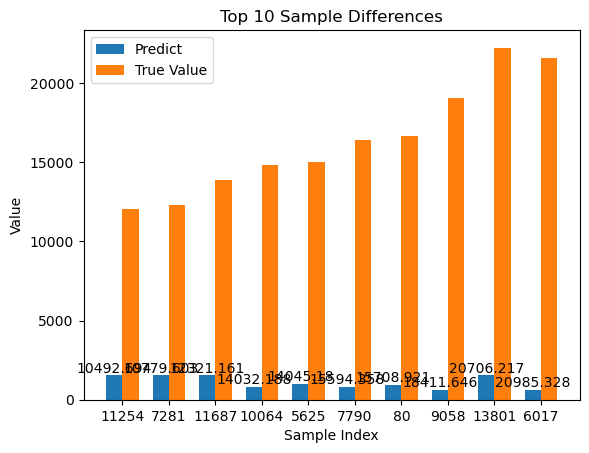

In [129]:
# 获取差异最大的10个样本的索引
top_10_indices = np.argsort(diff)[-10:]

# 提取差异最大的10个样本和其差异值
top_10_list1 = [pred_list[i] for i in top_10_indices]
top_10_list2 = [ground_list[i] for i in top_10_indices]
top_10_diff = [diff[i] for i in top_10_indices]

# 生成x轴坐标
x = np.arange(len(top_10_indices))

# 绘制柱状图
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, top_10_list1, width, label='Predict')
rects2 = ax.bar(x + width/2, top_10_list2, width, label='True Value')

# 添加差异值文本
for i, rect in enumerate(rects1):
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 5, top_10_diff[i],
            ha='center', va='bottom')

# 设置图表标签和标题
ax.set_xlabel('Sample Index')
ax.set_ylabel('Value')
ax.set_title('Top 10 Sample Differences')
ax.set_xticks(x)
ax.set_xticklabels(top_10_indices)
ax.legend()

plt.show()

In [109]:
# load test sample from test_public and convert to format as train_data
test_samples = pd.read_csv('test_public.csv')
# We first perform the same time parsing operation on the test dataset as we did with the training dataset
test_samples[["YR", "MON", "DAY", "HR", "WK"]] = test_samples[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

# Then, we map the TAXI_ID to the mean and std of the trip length (LEN) as we did with the train dataset
test_samples["TAXI_ID_MEAN"] = test_samples["TAXI_ID"].map(train_data.groupby("TAXI_ID")["LEN"].mean())
test_samples["TAXI_ID_STD"] = test_samples["TAXI_ID"].map(train_data.groupby("TAXI_ID")["LEN"].std())

# Similarly, we map the ORIGIN_CALL to the mean and std of LEN
test_samples["ORIGIN_CALL_MEAN"] = test_samples["ORIGIN_CALL"].map(train_data.groupby("ORIGIN_CALL")["LEN"].mean())
test_samples["ORIGIN_CALL_STD"] = test_samples["ORIGIN_CALL"].map(train_data.groupby("ORIGIN_CALL")["LEN"].std())

test_merge = test_samples.merge(taxi_stand, left_on="ORIGIN_STAND", right_on="ID")
# We remove rows where CALL_TYPE is 'B', as we did with the train dataset
test_samples = test_samples[test_samples["CALL_TYPE"] != "B"]

# drop useless columns in tran_merge
test_merge = test_merge.drop(columns=["ID", "ORIGIN_STAND", "Descricao"])
test_samples = test_samples.drop(columns=["ORIGIN_STAND"])
# add two columns to train_data, Latitude and Longitude, using NaN
test_samples["Latitude"] = np.nan
test_samples["Longitude"] = np.nan
# concat
test_samples = pd.concat([test_samples, test_merge])


In [110]:
# Convert CALL_TYPE to category
test_samples['CALL_TYPE'] = test_samples['CALL_TYPE'].astype('category')

# Convert Latitude and Longitude to float
test_samples['Latitude'] = test_samples['Latitude'].astype(float)
test_samples['Longitude'] = test_samples['Longitude'].astype(float)

# Apply one-hot encoding to CALL_TYPE
test_samples = pd.get_dummies(test_samples, columns=["CALL_TYPE"])

# Finally, we clip the values of TAXI_ID_MEAN, TAXI_ID_STD, ORIGIN_CALL_MEAN and ORIGIN_CALL_STD
test_samples["TAXI_ID_MEAN"] = test_samples["TAXI_ID_MEAN"].clip(train_data_final["TAXI_ID_MEAN"].mean() - 3 * train_data_final["TAXI_ID_STD"].std(), train_data_final["TAXI_ID_MEAN"].mean() + 3 * train_data_final["TAXI_ID_STD"].std())
test_samples["TAXI_ID_STD"] = test_samples["TAXI_ID_STD"].clip(train_data_final["TAXI_ID_STD"].mean() - 3 * train_data_final["TAXI_ID_STD"].std(), train_data_final["TAXI_ID_STD"].mean() + 3 * train_data_final["TAXI_ID_STD"].std())
test_samples["ORIGIN_CALL_MEAN"] = test_samples["ORIGIN_CALL_MEAN"].clip(train_data_final["ORIGIN_CALL_MEAN"].mean() - 3 * train_data_final["ORIGIN_CALL_STD"].std(), train_data_final["ORIGIN_CALL_MEAN"].mean() + 3 * train_data_final["ORIGIN_CALL_STD"].std())
test_samples["ORIGIN_CALL_STD"] = test_samples["ORIGIN_CALL_STD"].clip(train_data_final["ORIGIN_CALL_STD"].mean() - 3 * train_data_final["ORIGIN_CALL_STD"].std(), train_data_final["ORIGIN_CALL_STD"].mean() + 3 * train_data_final["ORIGIN_CALL_STD"].std())

In [111]:
trip_id = test_samples['TRIP_ID']
test_samples_drop = test_samples.drop(columns=["MISSING_DATA", "ORIGIN_CALL", "TAXI_ID", "TIMESTAMP", "TRIP_ID", "DAY_TYPE", "YR"])

In [145]:
pred = xgb.predict(test_samples_drop)

In [119]:
test_samples_torch = torch.tensor(test_samples_drop.fillna(0).values, dtype=torch.float32).to(device)
pred_torch = model(test_samples_torch).cpu().detach().numpy()

In [120]:
# align index
trip_id.reset_index(drop=True, inplace=True)
# pred = pd.DataFrame(pred, columns=['TRAVEL_TIME'])
pred_torch = pd.DataFrame(pred_torch, columns=['TRAVEL_TIME'])
# concat
# submission = pd.concat([trip_id, pred], axis=1)
submission_torch = pd.concat([trip_id, pred_torch], axis=1)

In [121]:
import csv

# Sample submission file that is given on kaggle
df_sample = pd.read_csv("sampleSubmission.csv")
df_sample["TRAVEL_TIME"] = 716.43

df_sample.set_index('TRIP_ID', inplace=True)
submission_torch.set_index('TRIP_ID', inplace=True)

df_sample.update(submission_torch)

# convert travel time to int
df_sample["TRAVEL_TIME"] = df_sample["TRAVEL_TIME"].astype(int)

df_sample.reset_index(inplace=True)

df_sample.to_csv("my_pred.csv", index=False)